In [1]:
%load_ext lab_black
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, ReLU
from keras.callbacks import EarlyStopping

In [3]:
data = pd.read_csv("../data/five_percent.csv").set_index("date")

target = "gas_price"
features = [col for col in data if col != target]

the_future = "2019-01-01"
train, test = data.loc[:the_future], data[the_future:]

X_train, X_test, y_train, y_test = (
    train[features],
    test[features],
    train[target],
    test[target],
)

In [4]:
arima = auto_arima(
    y_train,  # data
    X=X_train,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    d=0,
    max_d=3,
    trace=True,
)

In [5]:
goob = arima.predict(n_periods=X_test.shape[0], X=X_test)

In [6]:
# plt.plot(goob.values, color="red")
# plt.plot(y_test.values, color="blue")

In [7]:
WINDOW = 30
FORECAST = 1

In [8]:
def data_windower(data, target, window=11, forecast=10):
    x_windowed = []
    y_forecasted = []
    for i in range(window, len(data) - forecast):
        x_windowed.append(data.iloc[i - window : i].values)
        y_forecasted.append(data[target].iloc[i : i + forecast].values)

    return x_windowed, y_forecasted


X_train, y_train = data_windower(train, "gas_price", window=WINDOW, forecast=FORECAST)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [9]:
model = Sequential(
    [
        LSTM(500, return_sequences=True),
        Dropout(0.25),
        ReLU(),
        LSTM(500, return_sequences=True),
        Dropout(0.25),
        ReLU(),
        LSTM(500, return_sequences=True),
        Dropout(0.25),
        ReLU(),
        LSTM(500, return_sequences=False),
        Dropout(0.25),
        ReLU(),
        Dense(256),
        ReLU(),
        Dense(FORECAST),
    ]
)

model.compile(loss="mse", optimizer="adam")

stopper = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=25)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100000,
    batch_size=32,
    callbacks=stopper,
)

Epoch 1/100000
32/32 [==============================] - 22s 549ms/step - loss: 0.2291 - val_loss: 0.2357
Epoch 2/100000
32/32 [==============================] - 16s 515ms/step - loss: 0.0373 - val_loss: 0.3882
Epoch 3/100000
32/32 [==============================] - 16s 515ms/step - loss: 0.0314 - val_loss: 0.4158
Epoch 4/100000
32/32 [==============================] - 16s 516ms/step - loss: 0.0181 - val_loss: 0.2384
Epoch 5/100000
32/32 [==============================] - 17s 519ms/step - loss: 0.0155 - val_loss: 0.1588
Epoch 6/100000
32/32 [==============================] - 17s 518ms/step - loss: 0.0254 - val_loss: 0.2280
Epoch 7/100000
32/32 [==============================] - 17s 521ms/step - loss: 0.0155 - val_loss: 0.2887
Epoch 8/100000
32/32 [==============================] - 17s 517ms/step - loss: 0.0133 - val_loss: 0.1761
Epoch 9/100000
32/32 [==============================] - 16s 516ms/step - loss: 0.0135 - val_loss: 0.2169
Epoch 10/100000
32/32 [==============================] 

In [10]:
train_pred = model.predict(X_train)
train_pred.shape

40/40 [==============================] - 7s 149ms/step


(1262, 1)

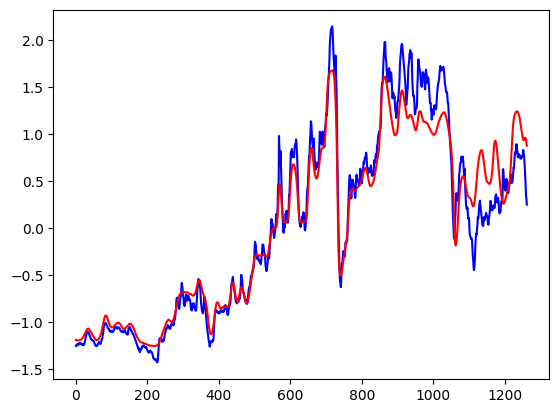

In [11]:
true_plot = y_train[:, -1]
pred_plot = train_pred[:, -1]

plt.plot(true_plot, color="blue")
plt.plot(pred_plot, color="red")

6/6 [==============================] - 2s 60ms/step


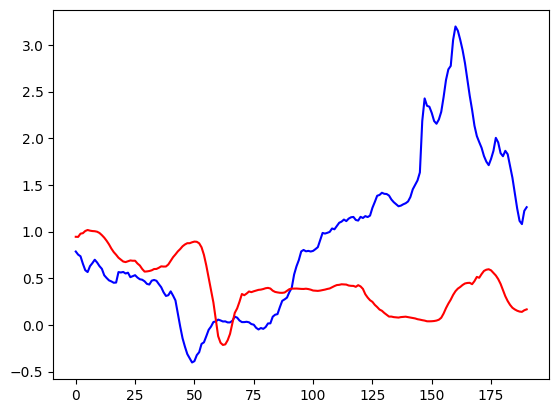

In [12]:
X_test, y_test = data_windower(test, "gas_price")

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

test_pred = model.predict(X_test)

true_plot = y_test[:, -1]
pred_plot = test_pred[:, -1]

plt.plot(true_plot, color="blue")
plt.plot(pred_plot, color="red")